In [1]:
import urllib
import os

def download_file(url, file=None):
    if file is None:
        file = os.path.basename(url)
    if os.path.exists(file):
        return file
    try:
        urllib.URLopener().retrieve(url, file)
    except:
        urllib.request.urlretrieve(url, file)
    return file

In [2]:
#image_file = download_file('https://github.com/pytorch/hub/raw/master/dog.jpg')
#image_file = 'goldenretriever-3724972_640.jpg'
image_file = download_file('https://upload.wikimedia.org/wikipedia/commons/b/b5/Canadian_Golden_Retriever.jpeg')

In [3]:
input_size = 225
win_size = 3
stride = 2
output_size = input_size // stride

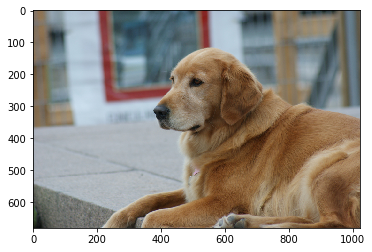

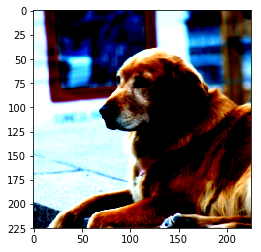

In [4]:
# sample execution (requires torchvision)
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

input_image = Image.open(image_file)
plt.imshow(input_image)
plt.show()

preprocess = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

disp_image = input_tensor.clone()
disp_image = disp_image.numpy().transpose((1, 2, 0))
disp_image = np.float32(disp_image)
disp_image = np.clip(disp_image, 0, 1)
plt.imshow(disp_image)
plt.show()

In [5]:
import numpy as np
import torch

x = np.random.rand(3, input_size, input_size)
x = np.float32(x)
input_tensor = torch.tensor(x)
input_batch2 = input_tensor.unsqueeze(0)

In [6]:
input_batch.shape

torch.Size([1, 3, 225, 225])

In [7]:
input_batch

tensor([[[[ 0.9132,  0.8961,  0.8961,  ..., -1.1418, -1.2445, -1.2788],
          [ 0.8789,  0.8961,  0.8961,  ..., -1.2617, -1.3815, -1.4158],
          [ 0.8789,  0.8789,  0.8789,  ..., -1.3987, -1.5185, -1.5528],
          ...,
          [-0.1486, -0.2684, -0.2856,  ...,  0.2796,  0.3309,  0.3481],
          [-0.0458, -0.1657, -0.2513,  ..., -0.0287, -0.0458, -0.0458],
          [ 0.0227, -0.0287, -0.3198,  ..., -0.1657, -0.2171, -0.2856]],

         [[ 1.3256,  1.3431,  1.3431,  ..., -0.7927, -0.9503, -0.9853],
          [ 1.3256,  1.3081,  1.3256,  ..., -0.9328, -1.1078, -1.1429],
          [ 1.2906,  1.3081,  1.3256,  ..., -1.0553, -1.2479, -1.2654],
          ...,
          [-0.0399, -0.1275, -0.1625,  ..., -0.1625, -0.1275, -0.1099],
          [ 0.0476, -0.0399, -0.1275,  ..., -0.4951, -0.5126, -0.5301],
          [ 0.1001,  0.0476, -0.1800,  ..., -0.6527, -0.6527, -0.7227]],

         [[ 1.8731,  1.8731,  1.8557,  ..., -0.5670, -0.6890, -0.7064],
          [ 1.8557,  1.8557,  

In [8]:
def define_trt_network(network):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, input_size, input_size))

    # MaxPool2d
    layer = network.add_pooling( \
        input=input_tensor, type=trt.PoolingType.MAX, window_size=(win_size, win_size))
    layer.stride = (stride, stride)

    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

In [9]:
import trt_analyzer
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine(logger):
    with trt.Builder(logger) as builder, builder.create_network(EXPLICIT_BATCH) as network:
        builder.max_workspace_size = 1 << 30
        # Define the TRT network using weights from the PyTorch model.
        #define_trt_plugin_network(network)
        define_trt_network(network)
        # Get network info
        global net_dict
        net_dict = trt_analyzer.network_dict(network)
        # Build and return an engine.
        return builder.build_cuda_engine(network)

In [10]:
import tensorrt as trt
import common

TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
net_dict = None
with build_engine(TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

In [11]:
import pandas as pd

pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [Pooling],LayerType.POOLING,"(1, 3, 225, 225)","(1, 3, 112, 112)","type=PoolingType.MAX wsize=(3, 3) stride=(2, 2..."


In [12]:
reference = trt_outputs[0].reshape((3, output_size, output_size))
print(reference)

[[[ 0.9131775   0.93030226  0.93030226 ... -0.33692956 -0.7650484
   -1.141793  ]
  [ 0.9131775   0.93030226  0.94742703 ... -0.23418105 -0.6451751
   -1.0219197 ]
  [ 0.94742703  0.96455175  0.96455175 ... -0.04580877 -0.31980482
   -0.49105233]
  ...
  [-0.08005828  0.00556549  0.00556549 ...  0.38231018  0.38231018
    0.27956167]
  [-0.14855729  0.00556549  0.00556549 ...  0.50218344  0.60493195
    0.60493195]
  [ 0.02269024 -0.09718303 -0.06293353 ...  0.17681314  0.27956167
    0.34806067]]

 [[ 1.3431373   1.3781513   1.3781513  ... -0.32002798 -0.547619
   -0.792717  ]
  [ 1.3431373   1.3781513   1.3956583  ... -0.26750696 -0.44257697
   -0.722689  ]
  [ 1.3956583   1.4306723   1.4306723  ... -0.09243695 -0.19747896
   -0.33753496]
  ...
  [ 0.03011205  0.13515405  0.13515405 ... -0.03991595 -0.03991595
   -0.17997196]
  [-0.03991595  0.13515405  0.13515405 ...  0.17016806  0.2051822
    0.2051822 ]
  [ 0.10014006  0.04761905  0.04761905 ... -0.23249297 -0.16246496
   -0.10994

In [13]:
import sys
import os

cur_path = %pwd
plugin_path = os.path.join(cur_path, 'plugin')
sys.path.append(plugin_path)
from trt_plugin_pb2 import copy_Message
from trt_plugin_pb2 import pooling_Message
import trt_plugin_pb2

In [14]:
import ctypes

lib_file = os.path.join(plugin_path, 'build', 'libPoolingPlugin.so')
lib = ctypes.CDLL(lib_file)

In [15]:
import tensorrt as trt

registry = trt.get_plugin_registry()
print([c.name for c in registry.plugin_creator_list])
print([c.plugin_namespace for c in registry.plugin_creator_list])

['RnRes2Br2bBr2c_TRT', 'RnRes2Br2bBr2c_TRT', 'RnRes2Br1Br2c_TRT', 'RnRes2Br1Br2c_TRT', 'CustomSkipLayerNormPluginDynamic', 'CustomEmbLayerNormPluginDynamic', 'CustomGeluPluginDynamic', 'CustomQKVToContextPluginDynamic', 'CustomFCPluginDynamic', 'SingleStepLSTMPlugin', 'pooling', 'copy']
['', '', '', '', '', '', '', '', '', '', 'macnica_trt_plugins', 'macnica_trt_plugins']


In [16]:
namespace = 'macnica_trt_plugins'
macnica_creators = [c for c in registry.plugin_creator_list if c.plugin_namespace == namespace]
for c in macnica_creators:
    registry.register_creator(c, namespace)

In [17]:
def define_trt_plugin_network(network):
    # Input
    input_tensor = network.add_input(name='input', dtype=trt.float32, shape=(1, 3, input_size, input_size))
    
    ### Custom Pooling Layer with CUDA or cuDNN ###
    creator = registry.get_plugin_creator( \
        type='pooling', version='1', plugin_namespace='macnica_trt_plugins')
    sz = input_tensor.shape
    message = pooling_Message( \
        dims=sz, mode=trt_plugin_pb2.Maximum, window=[win_size, win_size], \
        stride=[stride, stride], impl=trt_plugin_pb2.CUDA)
    plg = creator.deserialize_plugin('pooling', message.SerializeToString())
    layer = network.add_plugin_v2(inputs=[input_tensor], plugin=plg)

    # Output
    layer.get_output(0).name = 'output'
    network.mark_output(tensor=layer.get_output(0))

In [18]:
import trt_analyzer
import tensorrt as trt

EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

def build_engine2(logger):
    with trt.Builder(logger) as builder, builder.create_network(EXPLICIT_BATCH) as network:
        builder.max_workspace_size = 1 << 30
        # Define the TRT network using weights from the PyTorch model.
        define_trt_plugin_network(network)
        #define_trt_network(network)
        # Get network info
        global net_dict
        net_dict = trt_analyzer.network_dict(network)
        # Build and return an engine.
        return builder.build_cuda_engine(network)

In [19]:
net_dict = None
with build_engine2(TRT_LOGGER) as engine:
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    with engine.create_execution_context() as context:
        inputs[0].host = input_batch.numpy()
        trt_outputs = common.do_inference_v2( \
            context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

In [20]:
pd.DataFrame(net_dict)

,Name,Type,Inputs,Outputs,Type Specific Params
0,(Unnamed Layer* 0) [PluginV2Ext],LayerType.PLUGIN_V2,"(1, 3, 225, 225)","(1, 3, 112, 112)",


In [21]:
result = trt_outputs[0].reshape((3, output_size, output_size))
print(type(result[0][0][0]))
print(result)

<class 'numpy.float32'>
[[[ 0.9131775   0.93030226  0.93030226 ... -0.33692956 -0.7650484
   -1.141793  ]
  [ 0.9131775   0.93030226  0.94742703 ... -0.23418105 -0.6451751
   -1.0219197 ]
  [ 0.94742703  0.96455175  0.96455175 ... -0.04580877 -0.31980482
   -0.49105233]
  ...
  [-0.08005828  0.00556549  0.00556549 ...  0.38231018  0.38231018
    0.27956167]
  [-0.14855729  0.00556549  0.00556549 ...  0.50218344  0.60493195
    0.60493195]
  [ 0.02269024 -0.09718303 -0.06293353 ...  0.17681314  0.27956167
    0.34806067]]

 [[ 1.3431373   1.3781513   1.3781513  ... -0.32002798 -0.547619
   -0.792717  ]
  [ 1.3431373   1.3781513   1.3956583  ... -0.26750696 -0.44257697
   -0.722689  ]
  [ 1.3956583   1.4306723   1.4306723  ... -0.09243695 -0.19747896
   -0.33753496]
  ...
  [ 0.03011205  0.13515405  0.13515405 ... -0.03991595 -0.03991595
   -0.17997196]
  [-0.03991595  0.13515405  0.13515405 ...  0.17016806  0.2051822
    0.2051822 ]
  [ 0.10014006  0.04761905  0.04761905 ... -0.23249297

In [22]:
print(sum(abs(result.flatten() - reference.flatten())) / len(result.flatten()))

0.0


(3, 112, 112)


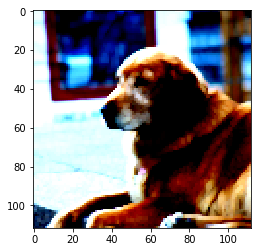

In [23]:
disp_image = result.reshape(3, output_size, output_size)
print(disp_image.shape)
disp_image = disp_image.transpose((1, 2, 0))
disp_image = np.clip(disp_image, 0, 1)
plt.imshow(disp_image)
plt.show()